In [1]:
import torch
import torch.nn as nn
import torch.optim as optm
import os
import json
from metrics_amazon import CM, f1_score0, f1_score1, Recall, Precision, ACC
import numpy as np
from preprocess import load_tif_image, extract_temporal_sorted_patches, extract_sorted_patches, divide_pred_windows
import matplotlib.pyplot as plt

import imageio
import matplotlib.animation as animation
from IPython.display import HTML
import cv2


/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def display_video(video, video_ref):
    fig, axs = plt.subplots(1, 2)
    ims = []
    for i in range(video.shape[0]):
        im1 = axs[0].imshow(video[i], animated=True)
        im2 = axs[1].imshow(video_ref[i], animated=True)
        ims.append([im1, im2])
    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
    plt.colorbar(im1, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])
    plt.tight_layout()
    plt.close()
    ani.save('animation.mp4', writer='ffmpeg')
    # return HTML(ani.to_jshtml())
    return HTML(ani.to_html5_video())

In [5]:
experiment = 'exp02_2'

preds = np.load(os.path.join('work_dirs', experiment, 'preds.npy'))
print(preds.shape)
# preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'img_reconstructed.npy'))
# def_preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'def_img_reconstructed.npy'))

mean_std = np.load(os.path.join('work_dirs', experiment, 'mean_std.npy'))

training_config = json.load(open(os.path.join('work_dirs', experiment, 'model_training.json')))
print(training_config)

(79248, 1, 2, 64, 64)
{'pre_seq_length': 4, 'aft_seq_length': 2, 'total_length': 6, 'batch_size': 64, 'val_batch_size': 64, 'epoch': 100, 'lr': 1e-05, 'metrics': ['mse', 'mae'], 'ex_name': 'exp02_2', 'in_shape': [4, 1, 64, 64], 'patience': 10, 'delta': 0.0001, 'amazon_mask': True, 'pixel_size': '1K', 'patch_size': 64, 'window_size': 6, 'overlap': 0.25, 'loss': 'focal', 'aux_metrics': ['CM'], 'normalize': True, 'scheduler_step_size': 1, 'scheduler_decay_factor': 0.95, 'optmizer': 'sgd', 'sgd_momentum': 0.8, 'focal_gamma': 4.7, 'focal_alpha': 0.01}


In [3]:
# Load Test Image
deter_img = load_tif_image('data/DETER/deter_increments_1km_1week.tif')

mask = load_tif_image('data/IBAMA_INPE/1K/tiff_filled/mask.tif')
mask = mask[:deter_img.shape[1], :deter_img.shape[2]]

deter_img[:, mask == 0] = -1
deter_img[deter_img > 0] = 1
deter_img_test = deter_img[(96 + 48):(96 + 48 + 48)]
del deter_img

In [27]:
print(deter_img_test.shape)
deter_img_test2 = deter_img_test.copy()

(48, 2333, 3005)


In [25]:
def_preds_reconstructed = np.load('work_dirs/exp02_2/def_preds_reconstructed.npy')

In [15]:
print(def_preds_reconstructed.shape)
for i in range(def_preds_reconstructed.shape[0]):
    print(i)
    def_preds_reconstructed[i][mask == 0] = -1
    deter_img_test2[i][mask == 0] = -1
    # display_video(def_preds_reconstructed[i])

(48, 2333, 3005)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [28]:
def_preds_reconstructed2 = def_preds_reconstructed.copy()
# def_preds_reconstructed2[def_preds_reconstructed2 > 0.3] = 1
deter_img_test2[deter_img_test2 > 0] = 1
display_video(def_preds_reconstructed2, deter_img_test2)

In [5]:
print(deter_img_test.shape)
print(mask.shape)

(48, 2333, 3005)
(2333, 3005)


In [6]:
test_patches = extract_temporal_sorted_patches(deter_img_test, training_config['patch_size'])
print('Test Patches:', test_patches.shape)

mask_test_patches = extract_sorted_patches(mask, training_config['patch_size'])
print('Mask Test Patches:', mask_test_patches.shape)

Test Patches: (48, 1656, 64, 64)
Mask Test Patches: (1656, 64, 64)


In [7]:
# test_files, mask_test_files, _ = divide_pred_windows(test_patches, min_def=0, window_size=training_config['total_length'],\
#     mask_patches=mask_test_patches)
test_patches = test_patches.transpose(1, 0, 2, 3)
test_files, mask_test_files, _ = divide_pred_windows(test_patches, min_def=0, window_size=training_config['total_length'])
# print(f'Test shape: {test_files.shape} - {mask_test_files.shape}')
print(f'Test shape: {test_files.shape}')
# del test_patches, mask_test_patches
del test_patches

Dividing in prediction windows:   0%|          | 0/71208 [00:00<?, ?it/s]/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Dividing in prediction windows: 100%|██████████| 71208/71208 [00:03<00:00, 22833.97it/s]


0 Skipped Images
Test shape: (71208, 6, 64, 64)


In [8]:
min_def = 0.005
skip_count = 0
def_indexes = []
def_means = []
for i in range(test_files.shape[0]):
    # print(f'Processing {i} of {test_files.shape[0]}')
    # test_files[i] = (test_files[i] - mean_std[0])/mean_std[1]
    patches = test_files[i]
    labels = patches[-2:]
    # _label = labels[:, mask_test_files[i] == 1]
    # _label[_label > 0] = 1
    # print(labels.shape)
    # mean = np.mean(_label, axis=(0, 1))
    mean = np.mean(labels, axis=(0, 1, 2))
    # 1/0
    # Deal with Nan
    if np.isnan(mean): mean = 0
    # if np.isnan(mean[0]): mean[0] = 0
    # if np.isnan(mean[1]): mean[1] = 0
    # if mean[0] < min_def or mean[1] < min_def:
    if mean < min_def:
    # if mean[0] + mean[1] < min_def:
        skip_count += 1
        # print('here')
        continue
    # print(mean.shape)
    # print(mean[0] + mean[1])
    def_indexes.append(i)
    def_means.append(mean)
    # patches_pred = preds[i, 1]
    # patches_pred[:, mask_test_files[i] == 0] = -1
    # patches[:, mask_test_files[i] == 0] = -1
    # print('finished')
    # break
print(f'Skipped {skip_count} patches')

Skipped 71030 patches


In [12]:
print(patches.shape)
# print(patches_pred.shape)
print(len(def_indexes))
print(len(def_means))
print(def_indexes)

(6, 64, 64)
277
277
[556, 562, 602, 799, 2253, 2255, 2256, 2300, 2301, 2302, 2605, 2610, 2651, 2652, 2691, 2692, 2693, 2694, 2695, 2696, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2785, 2791, 2792, 3812, 3813, 3817, 3858, 3859, 3862, 3863, 3864, 3865, 3866, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3916, 3917, 3950, 3951, 3952, 3957, 3958, 3959, 3960, 4048, 4102, 4292, 4293, 4294, 4339, 4340, 4385, 4386, 5514, 5515, 5555, 5556, 5562, 5563, 5564, 5603, 5604, 5608, 5609, 5991, 6037, 6038, 7688, 7693, 7694, 12595, 12907, 12908, 12909, 14160, 14206, 14252, 14253, 14292, 14512, 17112, 24464, 24465, 24466, 24510, 24511, 25849, 26851, 26852, 30465, 30522, 30523, 31022, 31068, 31069, 31114, 35418, 35419, 37121, 37122, 37672, 37673, 37718, 38578, 38579, 38773, 38774, 40424, 40425, 41931, 42022, 45246, 45376, 45377, 46617, 46760, 46975, 48318, 48319, 48487, 48488, 48547, 48548, 48970, 48971, 50014, 50015, 50143, 50144, 50145, 50146, 50281, 50330, 50331, 51932, 

In [9]:
filter_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (filter_size,filter_size))

49669
(79248, 1, 2, 64, 64)
(6, 64, 64)
0.0
0.0
0.0
0.0
0.0
0.0


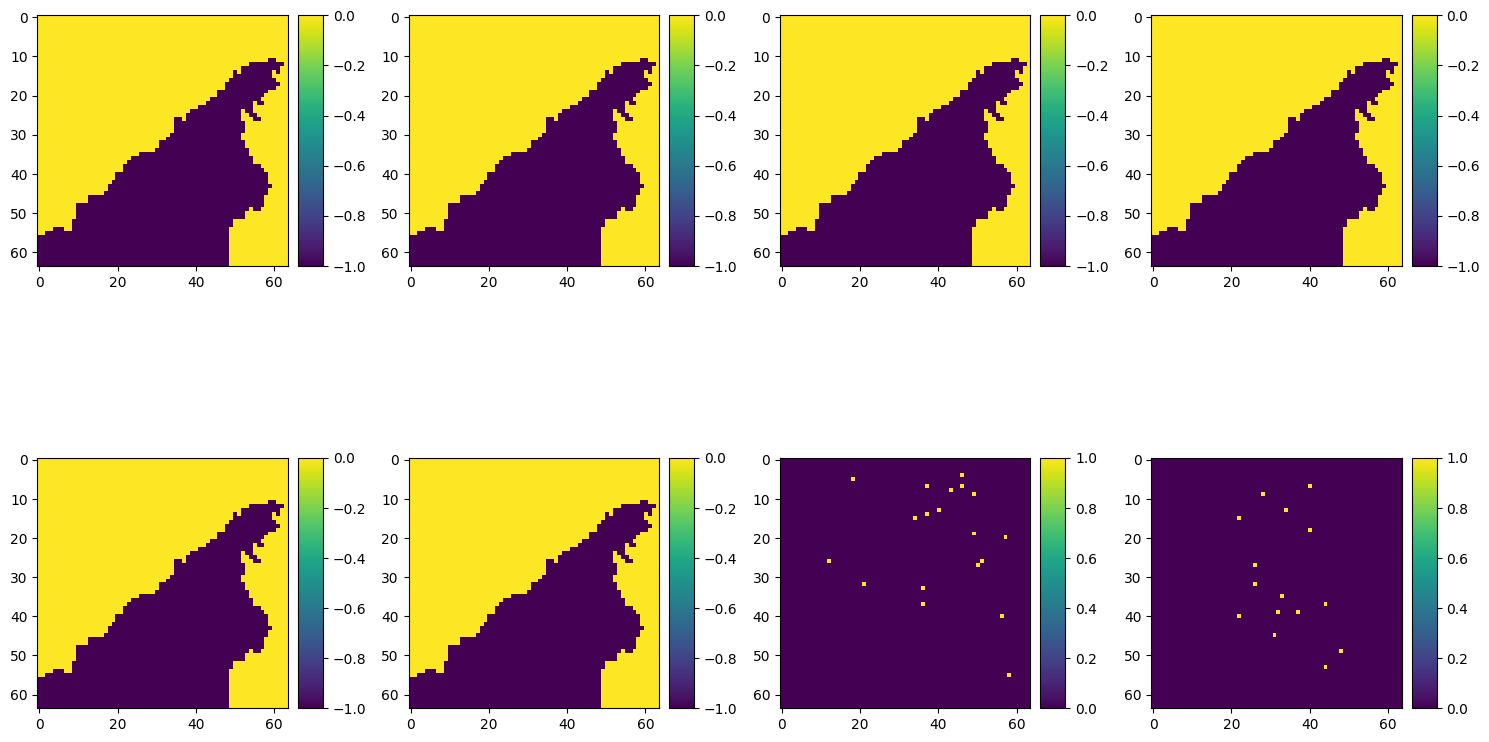

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pick a random number from the list
# index = np.random.choice(def_indexes)
index = np.random.choice(np.arange(71208))
# index = 37673
index = 49669
# index = index
# cont=0
# cont -= -1
# index = def_indexes[cont]
print(index)
print(preds.shape)
patches_pred = preds[index, 0]
patches2 = test_files[index]
patches = patches2.copy()
# patches_pred[:, mask_test_files[index] == 0] = -1
print(patches.shape)

# patches[patches > 0] = 1
# patches[patches < 0] = 0

# print(np.sum(patches[0]))
# print(np.sum(patches[1]))
for i in range(patches.shape[0]):
    patches_sum = patches[i]
    patches_sum = patches_sum[patches_sum != -1]
    # print(np.sum(patches[i]))
    print(np.sum(patches_sum))
    # if np.sum(patches[i]) > 0:
    if np.sum(patches_sum) > 0:
        # patches[i] = cv2.dilate(patches[i], kernel, iterations=1)
        pass
# patches = cv2.dilate(patches, kernel, iterations=1)
# patches[:, mask_test_files[index] == 0] = -1
    
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

patches_plot = np.concatenate((patches, patches_pred), axis=0)
for i in range(2):
    for j in range(4):
        im = axs[i, j].imshow(patches_plot[i*4 + j])
        divider = make_axes_locatable(axs[i, j])
        cax = divider.append_axes("right", size="10%", pad=0.1)
        fig.colorbar(im, cax=cax)
        # axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
#apply pred mask
for i in range(preds.shape[0]):
    # preds[i, :, patches_pred[i] == 1] = -1
    # patches_pred = preds[i, 1]
    # print(preds[i].shape)
    preds[i, :, :, mask_test_files[i] == 0] = -1

KeyboardInterrupt: 

In [58]:
print(preds.shape)

(79248, 2, 2, 64, 64)


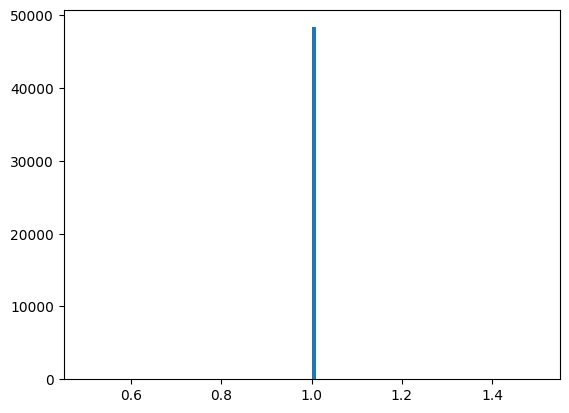

In [9]:
# def_preds = preds[:, 1]
# def_preds = def_preds[def_preds != -1]
test_files2 = test_patches.copy()
test_files2[test_files2 > 0] = 1
test_files2[test_files2 <= 0] = 0
test_files3 = test_files2[test_files2 == 1]
# Plot histogram
plt.hist(test_files3.reshape(-1), bins=100)
plt.show()

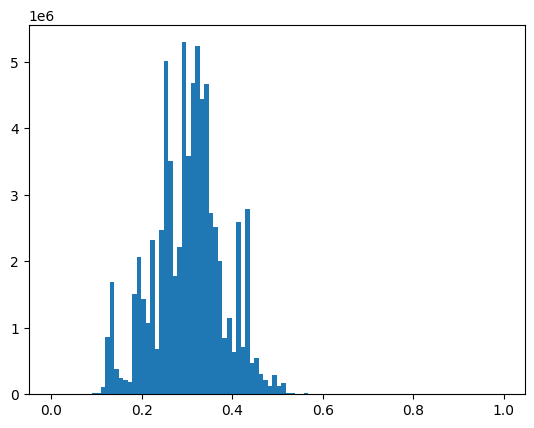

In [9]:
def_preds = preds[:, 1]
def_preds = def_preds[def_preds != -1]

# Plot histogram
plt.hist(def_preds, bins=100)
plt.show()

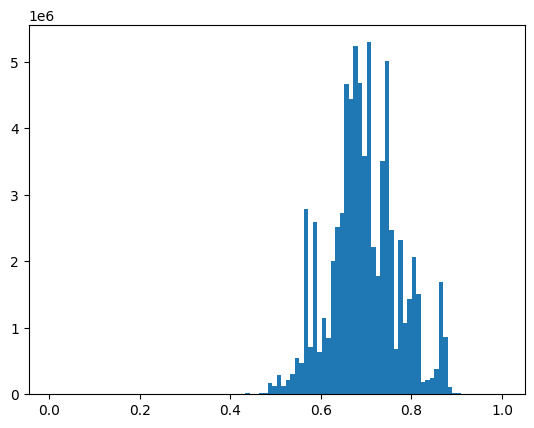

In [10]:
no_def_preds = preds[:, 0]
no_def_preds = no_def_preds[no_def_preds != -1]

# Plot histogram
plt.hist(no_def_preds, bins=100)
plt.show()